In [79]:

!  pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1

In [80]:
! pip install graphviz

In [81]:
! pip install fastbook fastai pandas scikit-learn dtreeviz IPython opendatasets numpy matplotlib seaborn --quiet


In [82]:
! pip install kaggle --quiet

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from fastai.imports import *
import pandas as pd
import numpy as np
import opendatasets as od
import os
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
from fastai.collab import *

path = untar_data(URLs.ML_100k)

In [4]:
path

Path('/root/.fastai/data/ml-100k')

In [5]:
ratings = pd.read_csv(
    path/'u.data', delimiter='\t', header=None,
    names=['user', 'movie', 'rating', 'timestamp']
)

In [6]:
ratings

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [7]:
# no extra data cleaning is required the dataset is look good
ratings.isna().sum()

user         0
movie        0
rating       0
timestamp    0
dtype: int64

In [8]:
ratings['rating'].unique()

array([3, 1, 2, 4, 5])

In [9]:
len(ratings['user'].unique())


943

In [10]:
len(ratings['movie'].unique())

1682

the movieLens dataset contains 25 million rows, we chose to work with subset of the data for learning purposes.

### creating the DataLoaders

In [11]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', 
                     usecols=(0,1), names=('movie','title'), header=None)

In [12]:
movies[movies['title'] == 'Kolya (1996)']

,movie,title
241,242,Kolya (1996)


Now we can merge the two dataframes the rating and the movie dataframes, inorder to see the title of the movie and for us humans working with user ids and movie titles is much better than working with the user ids and the movie ids. 

In [13]:
# merging the two tables on the movie id
ratings = ratings.merge(movies)

In [14]:
ratings

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)


In [15]:
dls = CollabDataLoaders.from_df(ratings, item_name='title',bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


nicely formatted output

In [16]:
# all the user ids and the movie titles in the dataset
# it will be useful to predict recommendation to existing users that watched any of the mentioned films 
# We need to find a way to take a sample of the movie names and make recommendations to users
# that will help me deal with the 25million data rows later in the 'future work' for this project.

dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [18]:
n_users = len(dls.classes['user']) # 900-ish
n_movies =len(dls.classes['title']) # 1600-ish

# for learning purposes we will use a embedding vector size of 5 factors -->
# --> for both the user and the movies distinct items
n_factors = 5
n_users

944

In [19]:
import torch
user_factors = torch.randn(n_users,n_factors)
movie_factors = torch.randn(n_movies,n_factors)
movie_factors.shape

torch.Size([1665, 5])

In [20]:
# since we will do a dot product of each index of the user_factors and the movie_factors
# we need to index in the matrices of both this factors and then perform the dot product
# but does this exist in deep learning, can a deep learning model do this by its own self ? 
# it turns out that it only knows how to matrix multiply and apply the activation function ....

# we as humans can actually do this kind of logic, by: 
    #  one_hot_encoding an index
    #  then dot product this one_hot_encoded index with the embedding matrix
    #  the result is the acutal values of that index inside the embedding matrix -- 'phenomenal'
    
# we will see an example: 
one_hot_3 = one_hot(3,n_users).float()

In [21]:
# @ --> dot product in pytorch
user_factors.t() @ one_hot_3  # look at the result, compare it to the cell below, mind-blowing

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [22]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

what can we do now? one_hot_encode thousands of values ? or what ? 
from the book: " We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—**we should just be able to index into an array directly with an integer.**"

the book, 08_collab.ipynb: " Therefore, most deep learning libraries, including **PyTorch**, include a special layer that does just this; it indexes into a vector using an integer, **but** has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an `embedding`. "


from the book: 👇🏼
- jargon: Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix.

how embeddings can learn the relationships between the users and movies: 👇🏼

from the book:

"""
<br>
Step 1 of this approach is to randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. 

Step 2 of this approach is to calculate our predictions. As we've discussed, we can do this by simply taking the dot product of each movie with each user. If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it or the user doesn't like action movies and the movie doesn't have any action in it. On the other hand, if we have a mismatch (a user loves action movies but the movie isn't an action film, or the user doesn't like action movies and it is one), the product will be very low.


Step 3 is to calculate our loss. We can use any loss function that we wish; MSE (mean square error for this example)

That's all we need. With this in place, we can optimize our parameters (that is, the latent factors) using stochastic gradient descent, such as to minimize the loss. At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and **will compare** it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.
<br>
"""


"**latent factors for each user and movie**" --> we are interseted in this bit here, the latent factors here will contain the final updated weights for those movies and user latent factors. those weights represents the relationship between the movies and the users, this movie is high in action, then one of the values of the latent factor for a single movie will be for how actiony it is. if a user likes action movies then for that specific user the latent factor given to him will contain the a one value representing how much he likes action movies. 

<br>
from the book:

"""
<br>
How do we determine numbers to characterize those? The answer is, we don't. We will let our model learn them. By analyzing the existing relations between users and movies, our model can figure out itself the features that seem important or not.

This is what embeddings are. We will attribute to each of our users and each of our movies a random vector of a certain length (here, n_factors=5), and we will make those learnable parameters. That means that at each step, when we compute the loss by comparing our predictions to our targets, we will compute the gradients of the loss with respect to those embedding vectors and update them with the rules of SGD (or another optimizer).

At the beginning, those numbers don't mean anything since we have chosen them randomly, but by the end of training, they will. By learning on existing data about the relations between users and movies, without having any other information, we will see that they still get some important features, and can isolate blockbusters from independent cinema, action movies from romance, and so on.

We are now in a position that we can **create our whole model from scratch.**
<br>
"""

### A Collaborative Filtering Model From Sctrach

In [23]:
from fastai.learner import Module
from fastai.layers import Embedding

class DotProduct(Module):
  def __init__(self,n_users,n_movies,n_factors,y_range=(1,5)):
    self.user_factors = Embedding(n_users,n_factors)
    self.movie_factors = Embedding(n_movies,n_factors) 
    self.y_range = y_range

  def forward(self,x):
    users = self.user_factors(x[:,0]) # dataframe first column
    movies = self.movie_factors(x[:,1]) # dataframe 2nd column
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)


In [24]:
# # debudding purposes
# L(DotProduct(n_users,n_movies,50).parameters())

In [25]:
x,y = dls.one_batch()
print(y.min(), y.max())

tensor(1, dtype=torch.int8) tensor(5, dtype=torch.int8)


In [29]:
model = DotProduct(n_users,n_movies,50)
# model(x)

In [30]:
learn = Learner(dls, model, loss_func=MSELossFlat()) # type:ignore 

SuggestedLRs(slide=0.02290867641568184, valley=0.0002290867705596611)

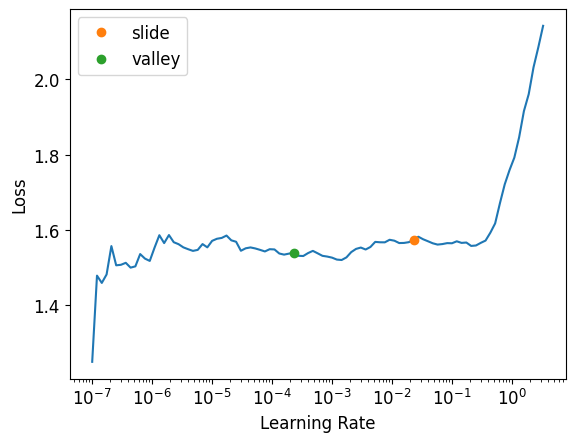

In [31]:
learn.lr_find(suggest_funcs=(slide,valley))

In [32]:
# # let's train the model on the data
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,time
0,1.397810,1.381178,00:09
1,0.960519,0.975173,00:09
2,0.879552,0.923016,00:08
3,0.864048,0.904729,00:10
4,0.811579,0.901392,00:09
